based on this blogpost:
* https://medium.com/@simonli_18826/basic-implementation-of-tensorflow-classification-of-titanic-survival-60a9fbcc7a35

In [ ]:
# this example uses 

In [32]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed

# get kaggle data

In [11]:
fetch_data = False
metadata = {
    'basepath' : '../data/',
    'dataset':'titanic',
    'train' : 'train.csv',
    'test' : 'test.csv'}

In [12]:
# make folder
# download .zip
# unzip
# remove the .zip
# (data is placed ../data/titanic)
if fetch_data:
    !mkdir -p {metadata['basepath']}
    !kaggle competitions download -c dataset {metadata['dataset']} -p {metadata['basepath']}
    !unzip -o {metadata['basepath']}{metadata['dataset']}.zip -d {metadata['basepath']}{metadata['dataset']}/
    !rm {metadata['basepath']}{metadata['dataset']}.zip

In [14]:
train = pd.read_csv("{basepath}/{dataset}/{train}".format(**metadata))
test = pd.read_csv("{basepath}/{dataset}/{test}".format(**metadata))

# Data cleaning

In [26]:
# TODO is it is not valid to concat???
# Should have pipeline to apply
df = pd.concat([train, test], axis=0, sort=True)

In [27]:
# 
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# replacing some titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

df['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Rev         8
Dr          8
Name: Title, dtype: int64

In [28]:

# impute missing Age values using median of Title groups
title_ages = dict(df.groupby('Title')['Age'].median())

# create a column of the average ages
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

In [30]:
df['Embarked'].fillna(method='backfill', inplace=True)

df['Family_Size'] = df['Parch'] + df['SibSp']

In [33]:
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))
   

In [34]:

X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

# Get data into tensorflow

In [38]:
Sex = tf.feature_column.categorical_column_with_vocabulary_list("Sex", ["female", "male"])
Embarked = tf.feature_column.categorical_column_with_vocabulary_list("Embarked", ["S", "C", "Q"])
Title = tf.feature_column.categorical_column_with_vocabulary_list("Title", ['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'])
Age = tf.feature_column.numeric_column("Age")
Fare = tf.feature_column.numeric_column("Fare")
Parch = tf.feature_column.numeric_column("Parch")
Pclass = tf.feature_column.numeric_column("Pclass")
SibSp = tf.feature_column.numeric_column("SibSp")
Family_Size = tf.feature_column.numeric_column("Family_Size")

feat_cols = [Sex, Embarked, Title, Age, Fare, Parch, Pclass, SibSp, Family_Size]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)



In [39]:

input_func=tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train,
                                               y=y_train,
                                               batch_size=100,
                                               num_epochs=None,
                                               shuffle=True)


model = tf.estimator.LinearClassifier(feature_columns = feat_cols)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp9w7681rk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [40]:
model.train(input_fn=input_func, max_steps=10000)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Please use `layer.add_weight` method instead.
Ins

INFO:tensorflow:global_step/sec: 468.836
INFO:tensorflow:loss = 0.3493223, step = 4500 (0.213 sec)
INFO:tensorflow:global_step/sec: 442.081
INFO:tensorflow:loss = 0.39949763, step = 4600 (0.227 sec)
INFO:tensorflow:global_step/sec: 498.967
INFO:tensorflow:loss = 0.27008203, step = 4700 (0.200 sec)
INFO:tensorflow:global_step/sec: 472.413
INFO:tensorflow:loss = 0.33019036, step = 4800 (0.213 sec)
INFO:tensorflow:global_step/sec: 447.185
INFO:tensorflow:loss = 0.25986117, step = 4900 (0.222 sec)
INFO:tensorflow:global_step/sec: 504.928
INFO:tensorflow:loss = 0.43754318, step = 5000 (0.201 sec)
INFO:tensorflow:global_step/sec: 479.614
INFO:tensorflow:loss = 0.30677116, step = 5100 (0.206 sec)
INFO:tensorflow:global_step/sec: 515.775
INFO:tensorflow:loss = 0.2787093, step = 5200 (0.194 sec)
INFO:tensorflow:global_step/sec: 513.075
INFO:tensorflow:loss = 0.36518943, step = 5300 (0.195 sec)
INFO:tensorflow:global_step/sec: 512.091
INFO:tensorflow:loss = 0.2695975, step = 5400 (0.195 sec)
INF

AttributeError: module 'tensorflow_core.estimator' has no attribute 'inputs'

In [41]:
pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_val,batch_size=len(X_val),shuffle=False)

predictions = list(model.predict(input_fn=pred_fn))
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])
    
from sklearn.metrics import classification_report
print(classification_report(y_val,final_preds))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp9w7681rk/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84        52
         1.0       0.81      0.74      0.77        39

    accuracy                   

## Boosted trees in tensorflow
- Based on this tutorial
    - https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding

In [48]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn


# Training and evaluation input functions
train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_val, y_val, shuffle=False, n_epochs=1)

Use indicator columns for categorical columns:
* https://stackoverflow.com/questions/48614819/items-of-feature-columns-must-be-a-featurecolumn-given-vocabularylistcategori

In [53]:
Sex = tf.feature_column.categorical_column_with_vocabulary_list("Sex", ["female", "male"])
Embarked = tf.feature_column.categorical_column_with_vocabulary_list("Embarked", ["S", "C", "Q"])
Title = tf.feature_column.categorical_column_with_vocabulary_list("Title", ['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'])
Age = tf.feature_column.numeric_column("Age")
Fare = tf.feature_column.numeric_column("Fare")
Parch = tf.feature_column.numeric_column("Parch")
Pclass = tf.feature_column.numeric_column("Pclass")
SibSp = tf.feature_column.numeric_column("SibSp")
Family_Size = tf.feature_column.numeric_column("Family_Size")

my_feat_cols = [tf.feature_column.indicator_column(Sex)
             ,tf.feature_column.indicator_column(Embarked)
             ,tf.feature_column.indicator_column(Title)
             ,Age
             ,Fare
             ,Parch
             ,Pclass
             ,SibSp
             ,Family_Size]


In [49]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}


In [55]:
est = tf.estimator.BoostedTreesClassifier(
    feature_columns = feat_cols
    , **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp7_bb3jsv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.


In [56]:
pd.Series(results).to_frame()

,0
accuracy,0.791209
accuracy_baseline,0.571429
auc,0.876726
auc_precision_recall,0.868989
average_loss,0.448644
label/mean,0.428571
loss,0.448644
precision,0.763158
prediction/mean,0.416799
recall,0.743590


# interpret the results

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [59]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp7_bb3jsv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
I

# Gain feature importance

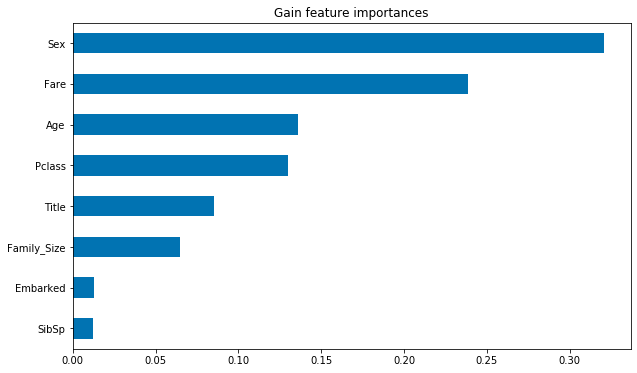

In [60]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

## Directional feature importance
- and single features

In [63]:
# Create DFC Pandas dataframe.
labels = y_val.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
Fare,91.0,0.006806,0.119509,-0.206441,-0.086512,-0.060730,0.106726,0.228795
Age,91.0,-0.019272,0.079569,-0.190580,-0.065946,-0.050475,0.010780,0.302057
Sex,91.0,0.003496,0.085779,-0.074865,-0.060885,-0.058927,0.117920,0.123684
Pclass,91.0,0.032292,0.078723,-0.094584,-0.024476,-0.013082,0.052105,0.177084
Title,91.0,0.008364,0.037254,-0.050664,-0.020392,-0.018933,0.037371,0.107159
Embarked,91.0,0.006186,0.019307,-0.033674,-0.000986,-0.000303,0.004470,0.059734
Family_Size,91.0,0.020324,0.060386,-0.223338,-0.000590,-0.000400,0.043066,0.260255
SibSp,91.0,-0.000921,0.012289,-0.042499,-0.004314,-0.000469,0.000878,0.043806
Parch,91.0,-0.000367,0.002871,-0.026622,0.000000,0.000000,0.000000,0.000000


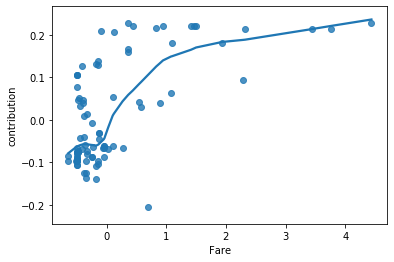

In [69]:
FEATURE = 'Fare'
feature = pd.Series(df_dfc[FEATURE].values, index=X_val[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
#ax.set_xlim(0, 1)
plt.show()

In [76]:
dfeval = X_val
y_eval = y_val


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-04T22:24:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp7_bb3jsv/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.68413s
INFO:tensorflow:Finished evaluation at 2020-05-04-22:24:36
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7912088, accuracy_baseline = 0.57142854, auc = 0.8767259, auc_precision_recall = 0.86898947, average_loss = 0.4486445, global_step = 100, label/mean = 0.42857143, loss = 0.4486445, precision = 0.7631579, prediction/mean = 0.4167991, recall = 0.74358976
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp7_bb3jsv/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mode

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-04T22:24:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp7_bb3jsv/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.56239s
INFO:tensorflow:Finished evaluation at 2020-05-04-22:24:44
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.8021978, accuracy_baseline = 0.57142854, auc = 0.8895464, auc_precision_recall = 0.87699527, average_loss = 0.42853048, global_step = 100, label/mean = 0.42857143, loss = 0.42853048, precision = 0.7837838, prediction/mean = 0.41722915, recall = 0.74358976
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /var/folders/02/kp7ssw2550vcb9ygw1021vlw0000gn/T/tmp7_bb3jsv/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling m

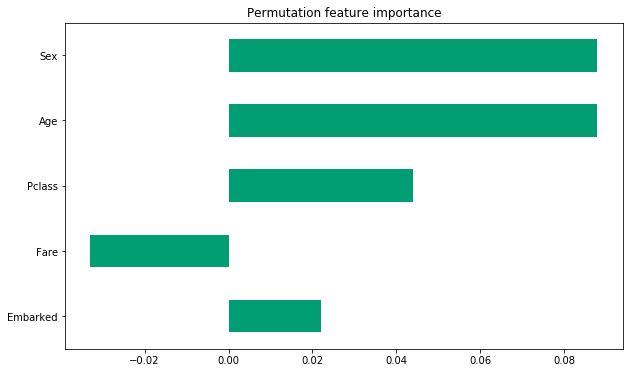

In [77]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']



features = list(X_val.columns.values)
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()